In [65]:
from __future__ import division
import pandas as pd
import numpy as np
import logging
import math
import time
import statistics as stats
import json
from datetime import datetime, timedelta
import os, sys
import matplotlib.pyplot as plt
import glob
from scipy.signal import medfilt, butter, filtfilt, lfilter, find_peaks, find_peaks_cwt,resample, detrend
from scipy.signal import welch, spectrogram, get_window
from scipy.stats import linregress
from scipy.interpolate import interp1d

In [66]:
data_path = "../data/open_vag/normal/novag1"
normal_dir = "../data/open_vag/normal/"
pathology_dir = "../data/open_vag/pathology/"

normal_vag_subjects = [] # 51
pathology_vag_subjects = [] # 38

# read all the files in the normal folder
novag_base_f = "novag"
ab_base_f  = "abvag"

# read normal files
for i, filename in enumerate(os.listdir(normal_dir)):
    file_path = os.path.join(normal_dir, f"{novag_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        vags = [float(x) for x in file.read().split()]
        normal_vag_subjects.append(vags)
        
# read pathology files
for i, filename in enumerate(os.listdir(pathology_dir)):
    file_path = os.path.join(pathology_dir, f"{ab_base_f}{i+1}")
    # Open the file for reading
    with open(file_path, 'r') as file:
        # Read all the floating-point numbers into a list
        p_vags = [float(x) for x in file.read().split()]
        pathology_vag_subjects.append(p_vags)

print(f"{len(normal_vag_subjects)} normal subjects")
print(f"{len(pathology_vag_subjects)} pathology subjects")

51 normal subjects
38 pathology subjects


In [67]:
# amplitude normalisation
def amplitude_normal(signal):
    sig = np.array(signal)
    data_min = min(sig)
    data_max = max(sig)
    normal = (sig - data_min) / (data_max - data_min)
    return normal.tolist()

def resample_signal(signal, points):
    s_res = resample(signal, points)
    return s_res

In [68]:
# variables
fs = 2000 # 2khz sampling rate

print(f"{len(normal_vag_subjects[38])} length of first normal subject data set")
print(f"{len(pathology_vag_subjects[28])} length of first pathology subject data set")

8000 length of first normal subject data set
8000 length of first pathology subject data set


In [87]:
n_norm = []
p_norm = []
n_norm_res = []
p_norm_res = []

n_l = 8192



for d_set in normal_vag_subjects:
    n = amplitude_normal(d_set)
    t = np.linspace(0, fs, num=len(n))  # Original x values (e.g., time or sample indices)
    # reasmple to 8192 which is the fft points required for these signals
    #n_res = resample(n, 8192)

    # Create new x values for the desired length
    x_new = np.linspace(t.min(), t.max(), n_l)
    
    # Create an interpolation function
    interpolator = interp1d(t, n, kind='linear')
    
    # Apply interpolation to get the new y values
    y_new = interpolator(x_new)
    
    n_norm_res.append(y_new)
    n_norm.append(n)

for d_set in pathology_vag_subjects:
    p = amplitude_normal(d_set)
    #p_res = resample(p, 8192)
    t = np.linspace(0, fs, num=len(p))  # Original x values (e.g., time or sample indices)
    # reasmple to 8192 which is the fft points required for these signals
    #n_res = resample(n, 8192)

    # Create new x values for the desired length
    x_new = np.linspace(t.min(), t.max(), n_l)
    
    # Create an interpolation function
    interpolator = interp1d(t, p, kind='linear')
    
    # Apply interpolation to get the new y values
    y_new = interpolator(x_new)
    p_norm_res.append(y_new)
    p_norm.append(p)



In [88]:
# apply a hanning window to each signal

def apply_hanning(d):
    hanning_window = np.hanning(len(d))
    windowed_signal = d * hanning_window
    return windowed_signal

n_hanning = []
p_hanning = []

for n in n_norm_res:
    n_hanning.append(apply_hanning(n))

for p in p_norm_res:
    p_hanning.append(apply_hanning(p))


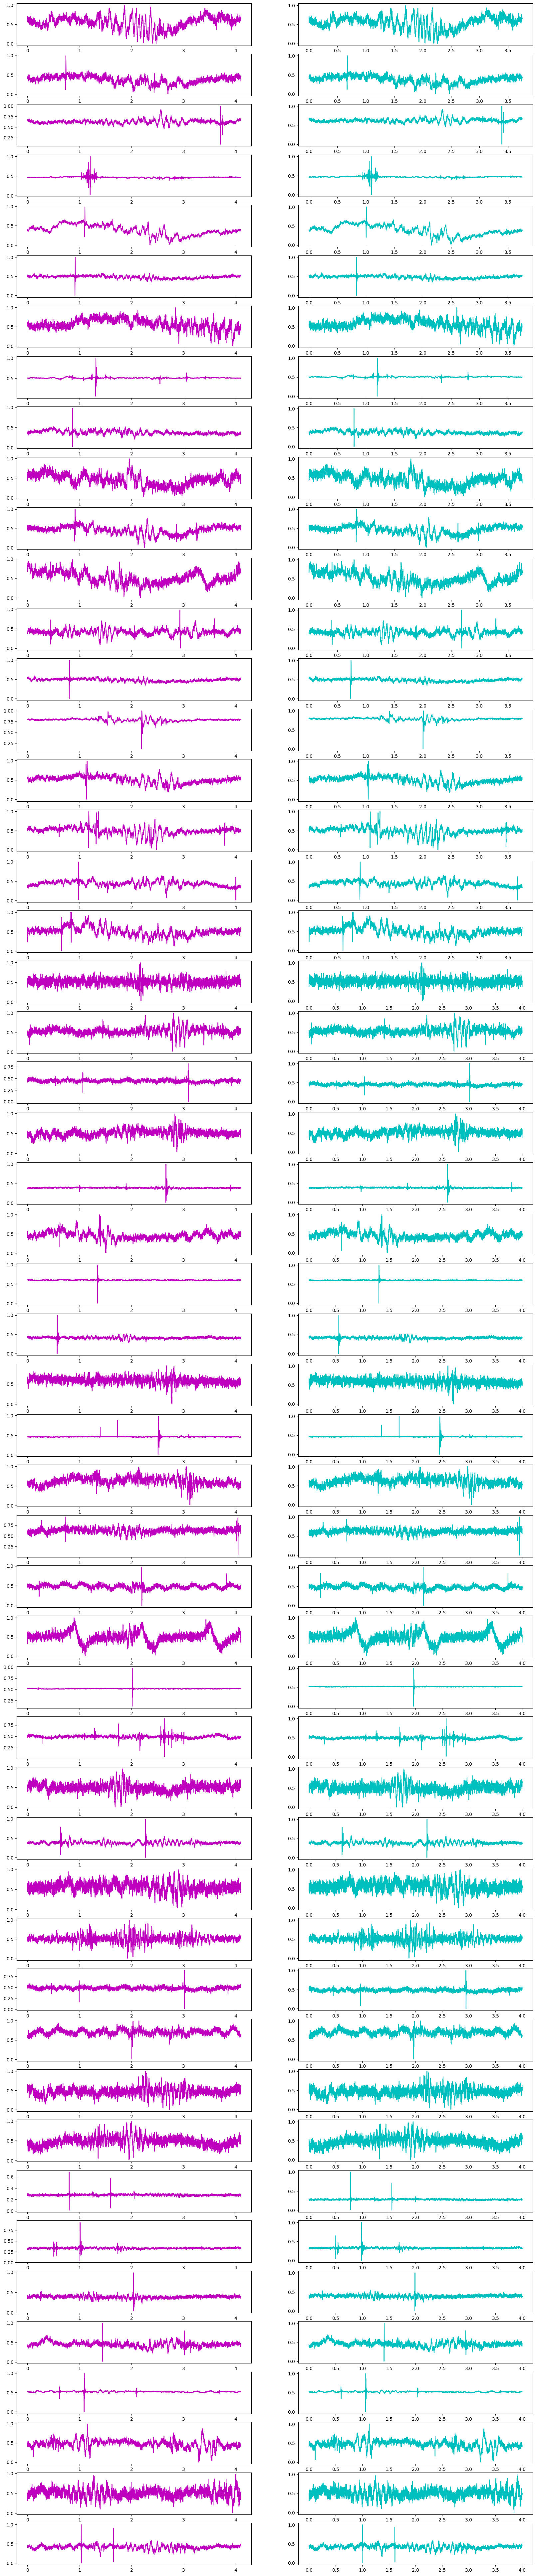

In [89]:
fig, ax = plt.subplots(len(n_norm),2, figsize=(20, 100))

for i, d in enumerate(n_norm_res):
    t_n = np.arange(1, len(d) + 1) / fs

    t_n_2 = np.arange(1, len(n_norm[i])+1) / fs
    ax[i][0].plot(t_n, d, color="m")
    ax[i][1].plot(t_n_2, n_norm[i], color="c")
    #ax[i][1].plot(t_n, n_hanning[i], color="black")

In [90]:
# functions
def compute_fft_mag(data):
    fftpoints = len(data) #int(math.pow(2, math.ceil(math.log2(len(data)))))
    fft = np.fft.fft(data, n=fftpoints)
    mag = np.abs(fft) #/ (fftpoints/2)
    return mag

# assumes a numpy arrray
def compute_power_spectrum(fft_mag):
    power = np.square(fft_mag)
    return power

In [91]:
# data sets n_norm and p_norm
#n_hanning_f = []
#p_hanning_f = []

# psd computed as the square magnitude of dft
n_pwr = []
n_pwr_freqs = []
p_pwr = []
p_pwr_freqs = []

for d_set in n_hanning:
    fftpoints =  len(d_set) #int(math.pow(2, math.ceil(math.log2(len(d_set)))))
    fft_mag = compute_fft_mag(d_set)
    #fft_graph = fft_graph_values(fft_mag, fs)
    f_power = compute_power_spectrum(fft_mag)
    #n_hanning_f.append(fft_graph)
    x = np.fft.fftfreq(fftpoints, d=1/fs)
    n_pwr_freqs.append(x)
    n_pwr.append(f_power)

for d_set in p_hanning:
    fftpoints =  len(d_set)
    fft_mag = compute_fft_mag(d_set)
    #fft_graph = fft_graph_values(fft_mag, fs)
    f_power = compute_power_spectrum(fft_mag)
    #p_hanning_f.append(fft_graph)
    x = np.fft.fftfreq(fftpoints, d=1/fs)
    p_pwr_freqs.append(x)
    p_pwr.append(f_power)



In [92]:
# line of best fit
n_log = []
p_log = []
n_best_fit = []
p_best_fit = []
n_slope = []
p_slope = []

for i, d_set in enumerate(n_pwr):
    #freqs = np.array(n_hanning_f[i][0])
    #positive_freqs = freqs[freqs > 0]
    # log - log 
    log_f = np.log10(n_pwr_freqs[i])
    #log_n_pwr = np.log10(n_pwr[i][freqs > 0])
    log_n_pwr = np.log10(n_pwr[i])
    
    n_log.append([log_f, log_n_pwr])
    # best fit
    indices = np.where((n_pwr_freqs[i] > 10) & (n_pwr_freqs[i] < 300))[0]
    x = log_f[indices]
    y = log_n_pwr[indices]
    m, b, r_value, p_value, std_err = linregress(x, y)
    #m, b = np.polyfit(x,y,1)
    n_slope.append(m)
    fit = m*x+b
    n_best_fit.append([log_f[indices], fit])

for i, d_set in enumerate(p_pwr):
    #freqs = np.array(p_hanning_f[i][0])
    #positive_freqs = freqs[freqs > 0]
    # log - log 
    log_f = np.log10(p_pwr_freqs[i])
    #log_p_pwr = np.log10(p_pwr[i][freqs > 0])
    log_p_pwr = np.log10(p_pwr[i])
    p_log.append([log_f, log_p_pwr])
    # best fit
    indices = np.where((p_pwr_freqs[i] > 10) & (p_pwr_freqs[i] < 300))[0]
    x = log_f[indices]
    y = log_p_pwr[indices]
    m, b, r_value, p_value, std_err = linregress(x, y)
    #m, b = np.polyfit(x,y,1)
    p_slope.append(m)
    fit = m*x+b
    p_best_fit.append([log_f[indices], fit])

/tmp/ipykernel_40128/1908552758.py:13: RuntimeWarning: divide by zero encountered in log10
  log_f = np.log10(n_pwr_freqs[i])
/tmp/ipykernel_40128/1908552758.py:13: RuntimeWarning: invalid value encountered in log10
  log_f = np.log10(n_pwr_freqs[i])
/tmp/ipykernel_40128/1908552758.py:32: RuntimeWarning: divide by zero encountered in log10
  log_f = np.log10(p_pwr_freqs[i])
/tmp/ipykernel_40128/1908552758.py:32: RuntimeWarning: invalid value encountered in log10
  log_f = np.log10(p_pwr_freqs[i])


In [93]:
# plot the fft
# plot the log log and line of best fit for one vag signal
#fig, ax = plt.subplots(1,1, figsize=(20, 5))
#ax.plot(n_hanning_f[10][0], n_hanning_f[10][1], color="m")


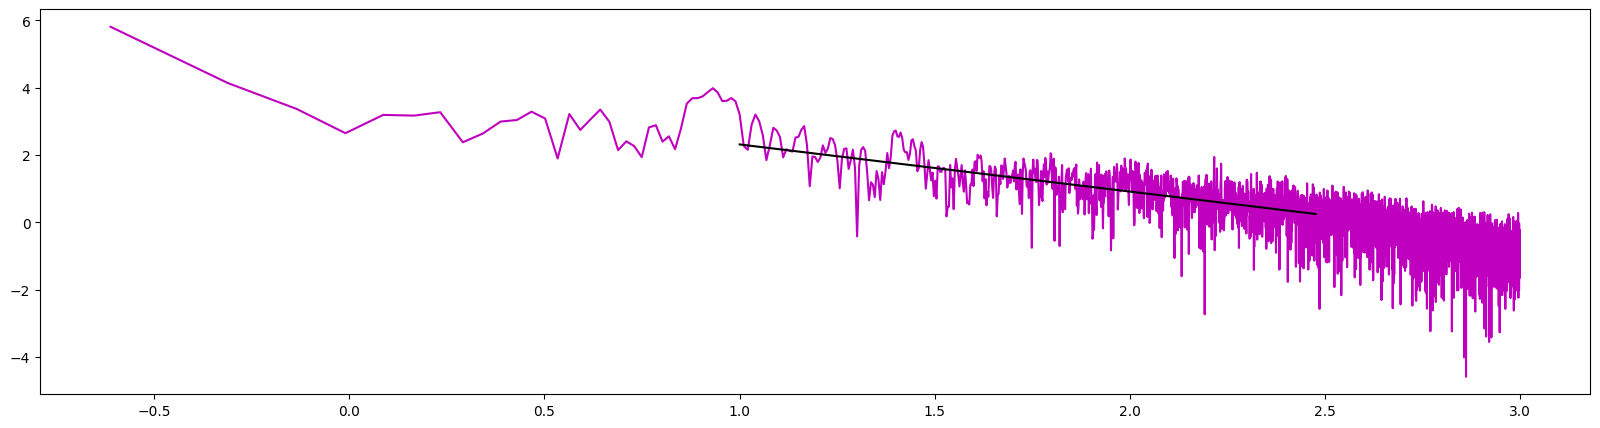

In [94]:
# plot the log log and line of best fit for one vag signal
fig, ax = plt.subplots(1,1, figsize=(20, 5))

ax.plot(n_log[10][0], n_log[10][1], color="m")
ax.plot(n_best_fit[10][0], n_best_fit[10][1], color="black")


In [95]:
# compare with built in log log fucntion
#fig, ax = plt.subplots(1,1, figsize=(20, 5))
#print(len(n_hanning_f[10][0]))
#ax.loglog(n_hanning_f[10][0], n_pwr[10], color="m")

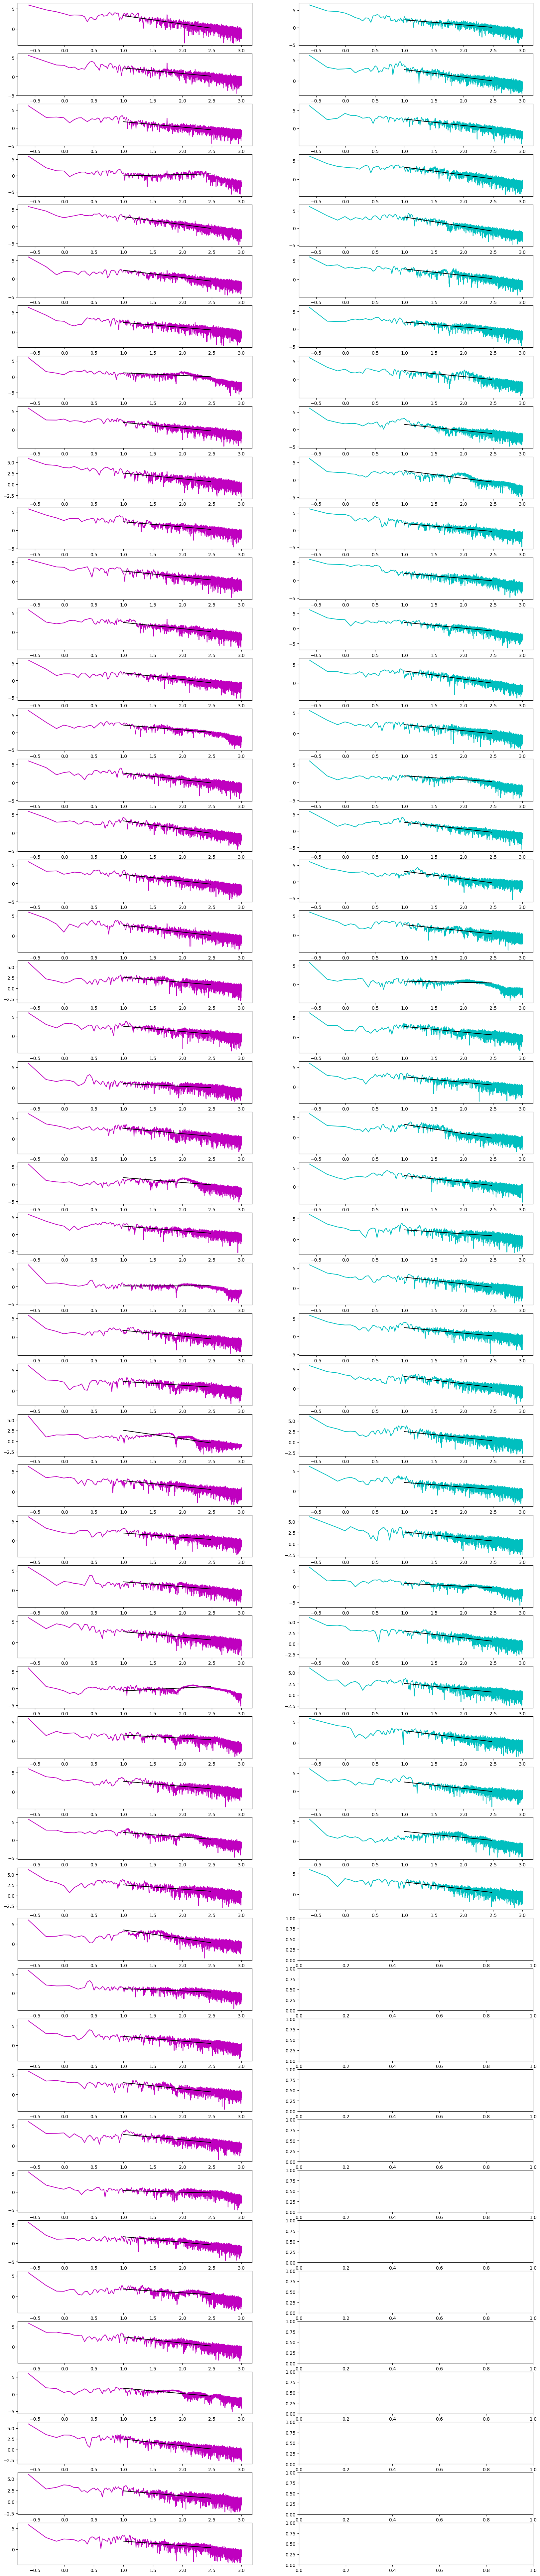

In [96]:
fig, ax = plt.subplots(len(n_log),2, figsize=(20, 100))

for i, d in enumerate(n_log):
    ax[i][0].plot(n_log[i][0], n_log[i][1], color="m")
    ax[i][0].plot(n_best_fit[i][0], n_best_fit[i][1], color="black")
    if i < len(p_log):
        ax[i][1].plot(p_log[i][0], p_log[i][1], color="c")
        ax[i][1].plot(p_best_fit[i][0], p_best_fit[i][1], color="black")

The best method available to estimate the FD of a self-affine signal is PSA. As explained in Section 1.1, an fBm signal has a PSD that
follows the 1/f model. A high value of ˇ indicates a rapid decrease
in the high-frequency content of the signal. A self-affine fBm function in an E-dimensional Euclidean space has its PSD PV(f) ∝ 1/f
with

FD = E + 1 − H
H = B - 1 /2

FD = E + 1 - ((B-1)/2))

If E = 1

FD = 5-B / 2

In [101]:
# the only way this comes out is if the slope is made a positive value if negative
def compute_fd(slope):
    fd = (5 - abs(slope)) / 2
    return fd

fd = compute_fd(n_slope[1])
fd_p = compute_fd(p_slope[9])
print(fd, fd_p)

1.7666073029267817 1.4127538364322934


the average and standard deviation values of FD for the 51 normal signals were 1.8061 ± 0.2398;
those for the 38 abnormal VAG signals were 1.6695 ± 0.2226 (using
the frequency range [10, 300] Hz).

In [98]:
# compute the FD assuming B is slope
n_norm_fd = []
p_norm_fd = []


for i, s in enumerate(n_slope):
    n_norm_fd.append(compute_fd(s))

for i, s in enumerate(p_slope):
    p_norm_fd.append(compute_fd(s))
    
print(f"avg fd normal: {float(np.mean(n_norm_fd))} +/- {round(np.std(n_norm_fd),4)}")
print(f"avg fd pathol: {np.mean(p_norm_fd)} +/- {round(np.std(p_norm_fd),4)}")



avg fd normal: 1.8231458599028687 +/- 0.2343
avg fd pathol: 1.6857154278161657 +/- 0.2181


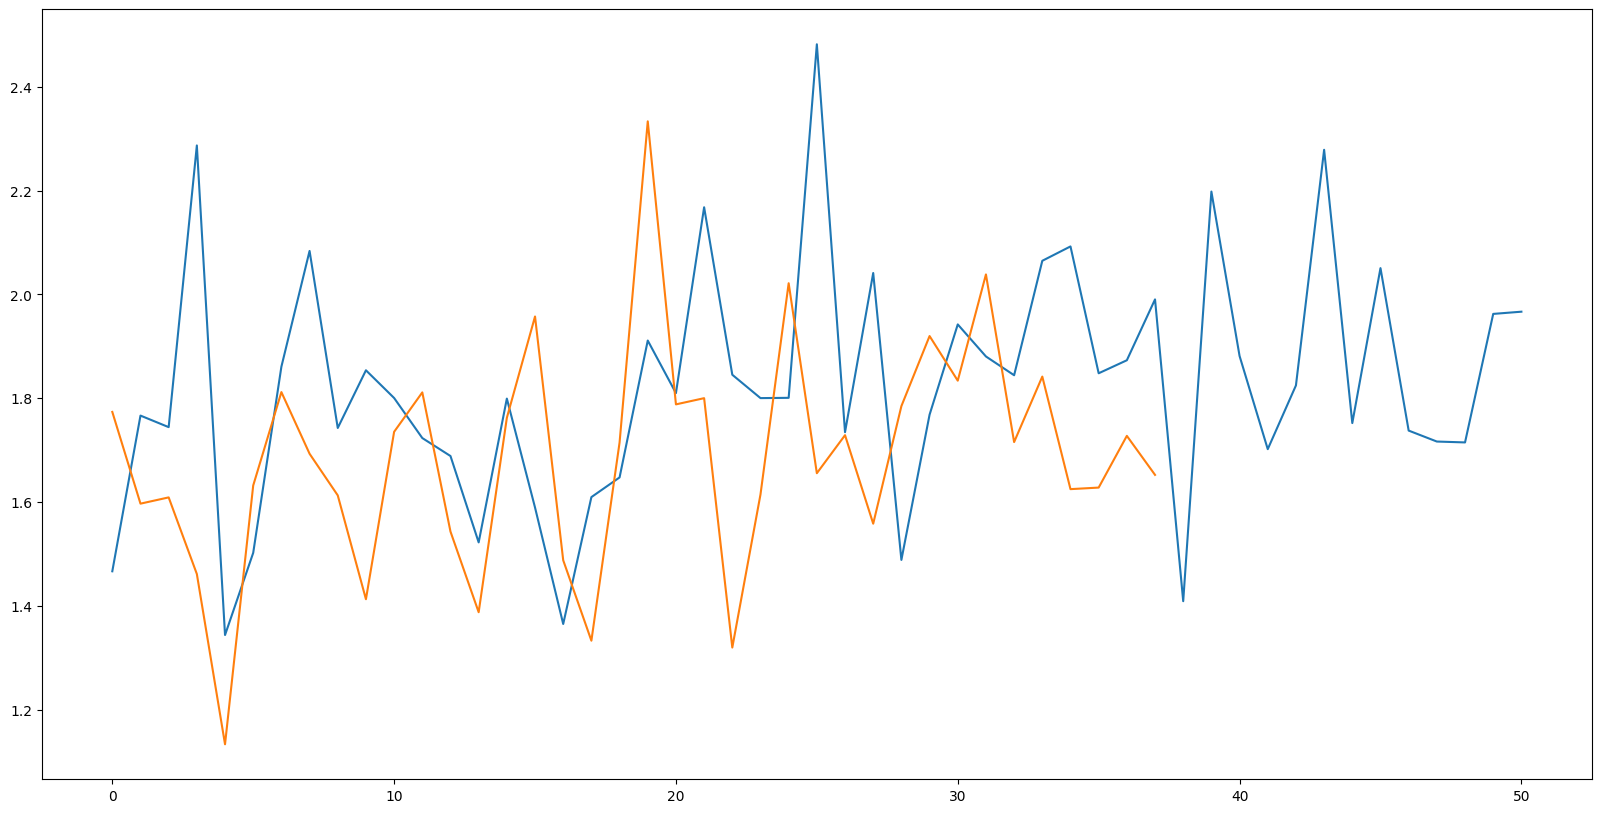

In [102]:
fig, ax = plt.subplots(1,1, figsize=(20, 10))
ax.plot(n_norm_fd)
ax.plot(p_norm_fd)